In [7]:
import numpy as np
import cupy as cp
import ray
import astropy.units as u
from IPython.display import clear_output
import time
from pathlib import Path
from matplotlib.patches import Circle
import copy
from importlib import reload

import warnings
warnings.filterwarnings("ignore")

import poppy

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import cgi_phasec_poppy as cgi
from cgi_phasec_poppy import misc
reload(cgi)

wavelength_c = 825e-9*u.m

nlam = 3
bandwidth = 0.10
minlam = wavelength_c * (1 - bandwidth/2)
maxlam = wavelength_c * (1 + bandwidth/2)
wavelengths = np.linspace( minlam, maxlam, nlam )

iwa = 5.9
owa = 20.1

data_dir = cgi.data_dir

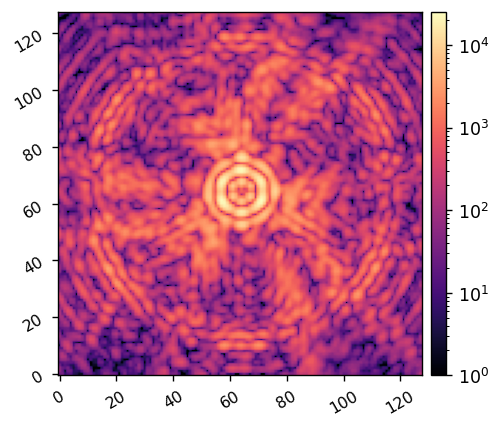

In [12]:
reload(cgi)
spc = cgi.CGI(cgi_mode='spc-wide', 
              psf_pixelscale_lamD=0.4, npsf=128, 
              use_pupil_defocus=True, use_opds=False,
              use_noise=True, 
              texp=60*u.s,
              star_flux=1e10*u.photon/u.m**2/u.s)
image = spc.snap()

misc.myimshow(image, lognorm=True)

In [4]:
poppy.conf.use_cupy = True
poppy.conf.use_mkl = True
poppy.conf.use_fftw = True

poppy_log.disabled = True

reload(cgi)
spcw = cgi.CGI(cgi_mode='spc-wide', 
               psf_pixelscale_lamD=0.2, npsf=256, 
               use_pupil_defocus=True, use_opds=False)
spcw_opds = cgi.CGI(cgi_mode='spc-wide', 
                    psf_pixelscale_lamD=0.2, npsf=256, 
                    use_pupil_defocus=True, use_opds=True)


# Test monochromatic PSFs.

Propagating wavelength 825.000 nm.
PSF calculated in 0.302s


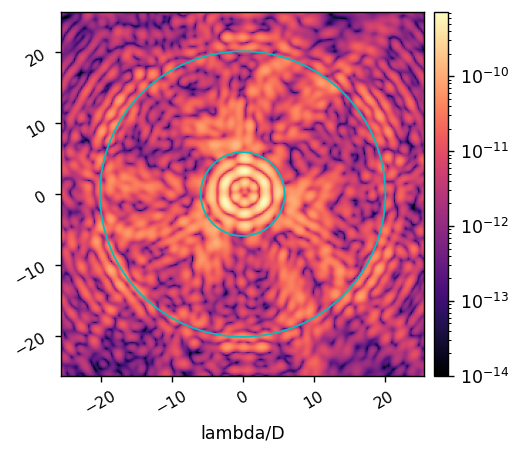

Saved data to:  /groups/douglase/kians-data-files/roman-cgi-phasec-data/spcw_gpu_wfs_mono


In [6]:
# Without OPDs
wf = spcw.calc_psf(quiet=False)

psf_mono = wf.intensity

patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
misc.myimshow(psf_mono, lognorm=True, pxscl=spcw.psf_pixelscale_lamD, patches=patches, vmin=1e-14)

if isinstance(psf_mono, np.ndarray):
    misc.save_pickle(data_dir/'spcw_cpu_wfs_mono', wf)
else:
    misc.save_pickle(data_dir/'spcw_gpu_wfs_mono', wf)

In [7]:
%%timeit
wf = spcw.calc_psf(quiet=True)

295 ms ± 711 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Propagating wavelength 825.000 nm.
PSF calculated in 0.460s


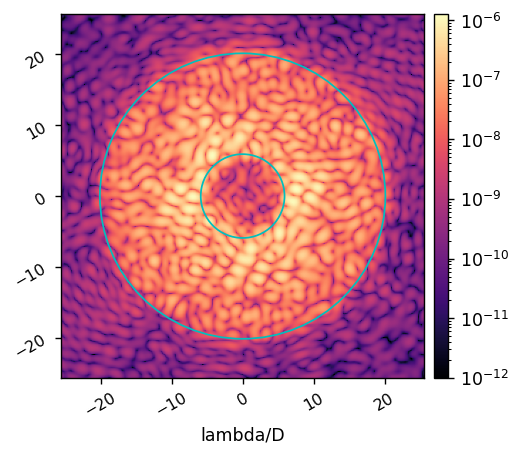

Saved data to:  /groups/douglase/kians-data-files/roman-cgi-phasec-data/spcw_gpu_wfs_mono_opds


In [8]:
# With OPDs
wf = spcw_opds.calc_psf(quiet=False)

psf_mono = wf.intensity

patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
misc.myimshow(psf_mono, lognorm=True, pxscl=spcw.psf_pixelscale_lamD, patches=patches, vmin=1e-12)

if isinstance(psf_mono, np.ndarray):
    misc.save_pickle(data_dir/'spcw_cpu_wfs_mono_opds', wf)
else:
    misc.save_pickle(data_dir/'spcw_gpu_wfs_mono_opds', wf)

In [9]:
%%timeit
wf = spcw_opds.calc_psf(quiet=True)

363 ms ± 505 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Test broadband PSFs.

In [10]:
settings = spcw.copy_mode_settings(nlam)
for i,sett in enumerate(settings):
    sett.update({'wavelength':wavelengths[i]})
settings

[{'cgi_mode': 'spc-wide',
  'wavelength': <Quantity 7.8375e-07 m>,
  'npsf': 256,
  'psf_pixelscale': <Quantity 8.58e-06 m / pix>,
  'interp_order': 3,
  'offset': (0, 0),
  'use_fpm': True,
  'use_fieldstop': False,
  'use_pupil_defocus': True,
  'use_opds': False,
  'dm1_ref': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  'dm2_ref': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  'polaxis': 0},
 {'cgi_mode': 'spc-wide',
  'wavelength': <Quantity 8.25e-07 m>,
  'npsf': 256,
  'psf_pixelscale': <Quantity 8.58e-06 m / pix>,
  'interp_order': 3,
  'offset': (0, 0),
  'use_fpm':

In [13]:
spcw_actors = cgi.cgi.create_actors(ncpus=10, ngpus=1/3, settings=settings)

In [15]:
reload(cgi)
wfs = cgi.cgi.calc_psfs(spcw_actors, quiet=False)

(CGI pid=99007) Propagating wavelength 825.000 nm.
(CGI pid=99008) Propagating wavelength 866.250 nm.
(CGI pid=99006) Propagating wavelength 783.750 nm.


(CGI pid=99007) /home/u21/kianmilani/src/poppy/poppy/geometry.py:215: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1
(CGI pid=99007)   warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1')
(CGI pid=99008) /home/u21/kianmilani/src/poppy/poppy/geometry.py:215: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1
(CGI pid=99008)   warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1')
(CGI pid=99006) /home/u21/kianmilani/src/poppy/poppy/geometry.py:215: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1
(CGI pid=99006)   warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1')
(CGI pid=99007) /home/u21/kianmilani/src/poppy/poppy/geometry.py:215: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale

All PSFs calculated in 0.911s
(CGI pid=99007) PSF calculated in 0.859s
(CGI pid=99008) PSF calculated in 0.857s
(CGI pid=99006) PSF calculated in 0.863s


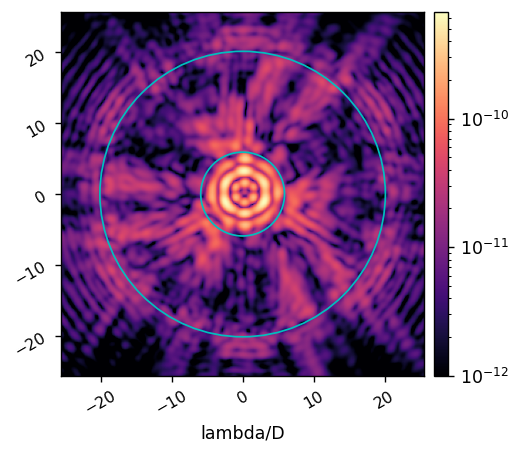

Saved data to:  /groups/douglase/kians-data-files/roman-cgi-phasec-data/spcw_gpu_wfs_broad


In [16]:
psf_broad = 0
for i in range(nlam):
    psf_broad += wfs[i].intensity/nlam

patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
misc.myimshow(psf_broad, lognorm=True, pxscl=spcw.psf_pixelscale_lamD, patches=patches, vmin=1e-12)

if isinstance(psf_broad, np.ndarray):
    misc.save_pickle(data_dir/'spcw_cpu_wfs_broad', wfs)
else:
    misc.save_pickle(data_dir/'spcw_gpu_wfs_broad', wfs)

In [17]:
%%timeit
wfs = cgi.cgi.calc_psfs(spcw_actors, quiet=True)

(CGI pid=99007) /home/u21/kianmilani/src/poppy/poppy/geometry.py:215: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1
(CGI pid=99007)   warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1')
(CGI pid=99008) /home/u21/kianmilani/src/poppy/poppy/geometry.py:215: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1
(CGI pid=99008)   warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1')
(CGI pid=99006) /home/u21/kianmilani/src/poppy/poppy/geometry.py:215: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1
(CGI pid=99006)   warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1')
(CGI pid=99007) /home/u21/kianmilani/src/poppy/poppy/geometry.py:215: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale

(CGI pid=99007) /home/u21/kianmilani/src/poppy/poppy/geometry.py:215: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1
(CGI pid=99007)   warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1')
(CGI pid=99007) /home/u21/kianmilani/src/poppy/poppy/geometry.py:215: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1
(CGI pid=99007)   warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1')
(CGI pid=99008) /home/u21/kianmilani/src/poppy/poppy/geometry.py:215: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1
(CGI pid=99008)   warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1')
(CGI pid=99008) /home/u21/kianmilani/src/poppy/poppy/geometry.py:215: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale

921 ms ± 27.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
